
### stacked map of galaxy pairs from pair catalog


Stacking pairs: 100%|██████████| 6549/6549 [00:02<00:00, 2387.71it/s]


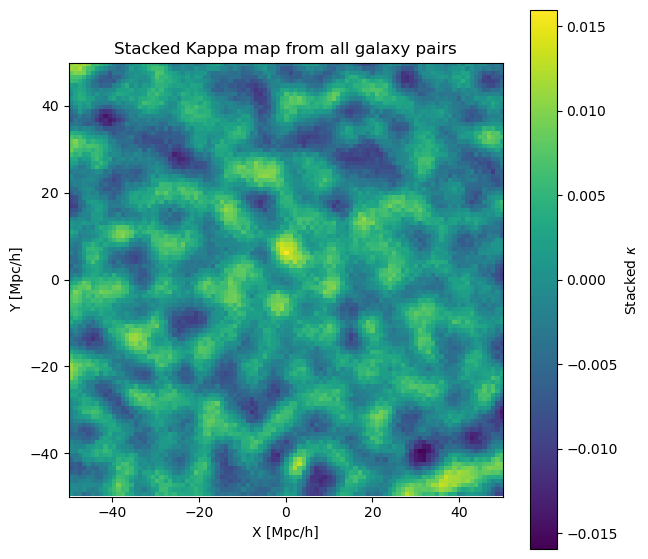

In [1]:
import numpy as np
import healpy as hp
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # progress bar

# --- Load catalog and map as before ---
pairs = pd.read_csv('data/galaxy_pairs_catalog.csv')
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"
nside = 2048

alm_data = hp.read_alm(alm_file)
lmax = hp.Alm.getlmax(len(alm_data))
kmap = hp.alm2map(hp.smoothalm(alm_data, fwhm=np.radians(8/60)), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Grid parameters ---
grid_size = 100.0  # Mpc/h box size
grid_res = 101
half_size = grid_size / 2
X_vals = np.linspace(-half_size, half_size, grid_res)
Y_vals = np.linspace(-half_size, half_size, grid_res)
X_grid, Y_grid = np.meshgrid(X_vals, Y_vals)

# Initialize stack accumulators
kappa_stack_sum = np.zeros((grid_res, grid_res))
weight_stack_sum = np.zeros((grid_res, grid_res))

# Loop over all pairs
for idx, pair in tqdm(pairs.iterrows(), total=len(pairs), desc="Stacking pairs"):
    # Extract pair data (convert to radians)
    l1, b1, z1 = np.deg2rad(pair['l1']), np.deg2rad(pair['b1']), pair['z1']
    l2, b2, z2 = np.deg2rad(pair['l2']), np.deg2rad(pair['b2']), pair['z2']

    # Compute center and comoving distance
    lc = 0.5 * (l1 + l2)
    bc = 0.5 * (b1 + b2)
    zbar = 0.5 * (z1 + z2)
    Dc = cosmo.comoving_distance(zbar).value  # Mpc/h

    # Rotation angle theta
    dl = (l2 - l1) * np.cos(bc)
    db = (b2 - b1)
    norm = np.sqrt(dl**2 + db**2)
    cos_theta = dl / norm
    sin_theta = db / norm

    # Inverse transform (X,Y) -> (l,b)
    dl_cosbc = (cos_theta * (X_grid / Dc)) - (sin_theta * (Y_grid / Dc))
    db_grid = (sin_theta * (X_grid / Dc)) + (cos_theta * (Y_grid / Dc))
    l_grid = lc + dl_cosbc / np.cos(bc)
    b_grid = bc + db_grid

    # Convert to degrees
    l_grid_deg = np.rad2deg(l_grid)
    b_grid_deg = np.rad2deg(b_grid)

    # Convert to Healpix pixels
    l_grid_deg_wrapped = np.mod(l_grid_deg, 360)
    theta = np.radians(90 - b_grid_deg)
    phi = np.radians(l_grid_deg_wrapped)
    pix = hp.ang2pix(nside, theta.ravel(), phi.ravel())

    # Sample kappa and mask
    kappa_vals = kmap[pix].reshape(grid_res, grid_res)
    mask_vals = mask[pix].reshape(grid_res, grid_res)

    # Mask out invalid pixels
    valid_mask = (mask_vals != 0) & np.isfinite(kappa_vals)
    kappa_vals[~valid_mask] = 0.0

    # Weights: if you have pair weights, use them here
    weight = 1.0  # equal weighting for now

    # Accumulate weighted sum and weights
    kappa_stack_sum += weight * kappa_vals
    weight_stack_sum += weight * valid_mask.astype(float)

# Avoid division by zero
nonzero = weight_stack_sum > 0
kappa_stack_mean = np.zeros_like(kappa_stack_sum)
kappa_stack_mean[nonzero] = kappa_stack_sum[nonzero] / weight_stack_sum[nonzero]

# Plot stacked map
plt.figure(figsize=(7,7))
extent = [-half_size, half_size, -half_size, half_size]
im = plt.imshow(kappa_stack_mean, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(im, label=r'Stacked $\kappa$')
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.title('Stacked Kappa map from all galaxy pairs')
plt.show()